In [1]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
Requirement already up-to-date: torch==1.5 in /usr/local/lib/python3.6/dist-packages (1.5.0+cu101)
Requirement already up-to-date: torchvision==0.6 in /usr/local/lib/python3.6/dist-packages (0.6.0+cu101)
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-sbqey8vy
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-sbqey8vy
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=267013 sha256=1c475579b0f9fcbbaea9b49ec7e5f29755664235f0b852a9c8b4791bb0be0f5e
  Stored in directory: /tmp/pip-ephem-wheel-cache-y5k_svie/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundat

In [2]:
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html


In [3]:
pip install wandb

In [4]:
# You may need to restart your runtime prior to this, to let your installation take effect
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import pandas as pd
import json
import os
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog  
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog

1.5.0+cu101 True


In [5]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
data_path = os.path.join(os.getcwd(), 'gdrive', 'My Drive', 'Colab Notebooks', 'dataset')
# data paths
train_path = os.path.join(data_path, 'train') 
test_path = os.path.join(data_path, 'test')
val_path = os.path.join(data_path, 'validation')

# train_path = os.path.join(data_path, 'train_small') 
# test_path = os.path.join(data_path, 'test_small')
# val_path = os.path.join(data_path, 'validation_small')

# label files
with open(os.path.join(data_path, 'train.json')) as f:
    train_labels = json.load(f)
with open(os.path.join(data_path, 'test.json')) as f:
    test_labels = json.load(f)
with open(os.path.join(data_path, 'val.json')) as f:
    val_labels = json.load(f)

# with open(os.path.join(data_path, 'train_small.json')) as f:
#     train_labels = json.load(f)
# with open(os.path.join(data_path, 'test_small.json')) as f:
#     test_labels = json.load(f)
# with open(os.path.join(data_path, 'val_small.json')) as f:
#     val_labels = json.load(f)

In [0]:
# need to change image path and set bbox_mode to 
for ind, elem in enumerate(train_labels):
    train_labels[ind]['file_name'] = os.path.join(train_path, train_labels[ind]['image_id'] + '.jpg')
    for ind2, elem2 in enumerate(train_labels[ind]['annotations']):
        train_labels[ind]['annotations'][ind2]['bbox_mode'] = BoxMode.XYXY_ABS

for ind, elem in enumerate(test_labels):
    test_labels[ind]['file_name'] = os.path.join(test_path, test_labels[ind]['image_id'] + '.jpg')
    for ind2, elem2 in enumerate(test_labels[ind]['annotations']):
        test_labels[ind]['annotations'][ind2]['bbox_mode'] = BoxMode.XYXY_ABS
  
for ind, elem in enumerate(val_labels):
    val_labels[ind]['file_name'] = os.path.join(val_path, val_labels[ind]['image_id'] + '.jpg')
    for ind2, elem2 in enumerate(val_labels[ind]['annotations']):
        val_labels[ind]['annotations'][ind2]['bbox_mode'] = BoxMode.XYXY_ABS

In [8]:
val_labels[0] # detectron2 style labels

{'annotations': [{'bbox': [0.0, 0.5952, 1024.0, 768.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 24}],
 'file_name': '/content/gdrive/My Drive/Colab Notebooks/dataset/validation/007f71665b0812a7.jpg',
 'height': 768,
 'image_id': '007f71665b0812a7',
 'width': 1024}

In [0]:
# returns dataset
def get_data_dicts(d):
    if d == 'train':
        return train_labels
    elif d == 'val':
        return val_labels
    elif d == 'test':
        return test_labels

# register dataset
for d in ["train", "val", "test"]:
    DatasetCatalog.register("data_" + d, lambda d=d: get_data_dicts(d))

    # large dataset
    MetadataCatalog.get("data_" + d).set(thing_classes=['Bathtub', 'Bed', 'Billiard table', 'Ceiling fan', 'Coffeemaker', 'Couch',
                                                        'Countertop', 'Dishwasher', 'Fireplace', 'Fountain', 'Gas stove', 'Jacuzzi',
                                                        'Kitchen & dining room table', 'Microwave oven', 'Mirror', 'Oven', 'Pillow',
                                                        'Porch', 'Refrigerator', 'Shower', 'Sink', 'Sofa bed', 'Stairs', 'Swimming pool',
                                                        'Television', 'Toilet', 'Towel', 'Tree house', 'Washing machine', 'Wine rack']).set(evaluator_type='coco')
    
    # small dataset
    #MetadataCatalog.get("data_" + d).set(thing_classes=['Bathtub', 'Coffeemaker', 'Gas Stove']).set(evaluator_type='coco')

data_metadata = MetadataCatalog.get("data_train")

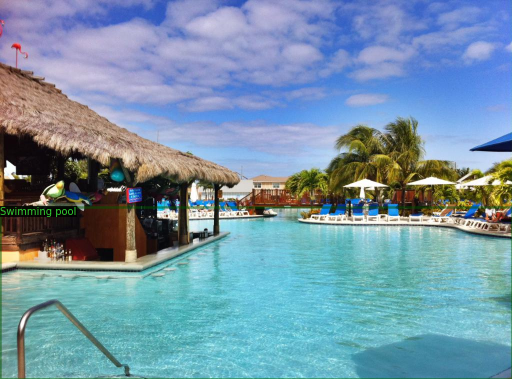

In [10]:
img = cv2.imread(os.path.join(val_path, os.listdir(val_path)[3]))
visualizer = Visualizer(img[:, :, ::-1], metadata=data_metadata, scale=0.5)
vis = visualizer.draw_dataset_dict(val_labels[3])
cv2_imshow(vis.get_image()[:, :, ::-1])

In [11]:
val_labels[3] # detectron2 style labels

{'annotations': [{'bbox': [0.0, 413.9832160000001, 1024.0, 757.892364],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 23}],
 'file_name': '/content/gdrive/My Drive/Colab Notebooks/dataset/validation/019347cc4772963d.jpg',
 'height': 758,
 'image_id': '019347cc4772963d',
 'width': 1024}

**Training Model**

In [0]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import wandb
import yaml

import logging
import os
from collections import OrderedDict
import torch
from torch.nn.parallel import DistributedDataParallel


import detectron2.utils.comm as comm
from detectron2.checkpoint import DetectionCheckpointer, PeriodicCheckpointer
from detectron2.config import get_cfg
from detectron2.data import (
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)
from detectron2.engine import default_argument_parser, default_setup, launch
from detectron2.evaluation import (
    COCOEvaluator,
    inference_on_dataset,
    print_csv_format,
)

from detectron2.modeling import build_model
from detectron2.solver import build_lr_scheduler, build_optimizer
from detectron2.utils.events import (
    CommonMetricPrinter,
    EventStorage,
    JSONWriter,
    TensorboardXWriter,
)

In [13]:
! wandb login

wandb: You can find your API key in your browser here: https://app.wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: a4ab5d8a6171fab0904b85d2244903a17e38dab8
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [0]:
# detectron2 models
# FPN = Feature Pyramid Network
# RPN = Region Proposal Network
# 3x learning rate scheduler tend to perform better compared to 1x learning rate scheduler
# FPN: Use a ResNet+FPN backbone with standard conv and FC heads for mask and box prediction, respectively. It obtains the best speed/accuracy tradeoff, but the other two are still useful for research.

# Full Model Description: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md

models_to_try = {'R50-FPN-3x': 'COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml',
                 'R101-FPN-3x': 'COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml',
                 'RN-50-3x': 'COCO-Detection/retinanet_R_50_FPN_3x.yaml',
                 'RN-101-3x': 'COCO-Detection/retinanet_R_101_FPN_3x.yaml'}


logger = logging.getLogger("detectron2")

In [0]:
# Base File: https://github.com/facebookresearch/detectron2/blob/master/tools/plain_train_net.py
# This code rewrites the default trainer such that we can use Weights and Biases to keep track of our experiments

def get_evaluator(cfg, dataset_name, output_folder=None):
    """
    Create evaluator(s) for a given dataset.
    This uses the special metadata "evaluator_type" associated with each builtin dataset.
    For your own dataset, you can simply create an evaluator manually in your
    script and do not have to worry about the hacky if-else logic here.
    """
    # changed to only return COCO evaluator (simpler)
    if output_folder is None:
        output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
    evaluator_list = []
    evaluator_type = MetadataCatalog.get(dataset_name).evaluator_type
    return COCOEvaluator(dataset_name, cfg, True, output_folder)
    
def do_test(cfg, model):
    # return list of results
    results = OrderedDict()
    for dataset_name in cfg.DATASETS.TEST:
        data_loader = build_detection_test_loader(cfg, dataset_name)
        evaluator = get_evaluator(
            cfg, dataset_name, os.path.join(cfg.OUTPUT_DIR, "inference", dataset_name)
        )
        results_i = inference_on_dataset(model, data_loader, evaluator)
        results[dataset_name] = results_i
        if comm.is_main_process():
            logger.info("Evaluation results for {} in csv format:".format(dataset_name))
            print_csv_format(results_i)
    if len(results) == 1:
        results = list(results.values())[0]
    return results


def do_train(cfg, model, resume=False, choosen_model='R50-FPN-3x'):
    # training
    model.train()
    optimizer = build_optimizer(cfg, model)
    scheduler = build_lr_scheduler(cfg, optimizer)

    checkpointer = DetectionCheckpointer(
        model, cfg.OUTPUT_DIR, optimizer=optimizer, scheduler=scheduler
    )
    
    # if resume training
    if resume == True:
        cfg.MODEL.WEIGHTS = os.path.join(os.getcwd(), 'gdrive', 'My Drive', 'Colab Notebooks', 'output') + '/model_0014999.final.pth' ### INSERT YOUR MODEL PATH HERE
        start_iter = (
            checkpointer.resume_or_load(cfg.MODEL.WEIGHTS, resume=resume).get("iteration", -1) + 1
        )
    else:
        start_iter = (
            checkpointer.resume_or_load(cfg.MODEL.WEIGHTS, resume=resume).get("iteration", -1) + 1
        )


    max_iter = cfg.SOLVER.MAX_ITER

    periodic_checkpointer = PeriodicCheckpointer(
        checkpointer, cfg.SOLVER.CHECKPOINT_PERIOD, max_iter=max_iter
    )

    writers = (
        [
            CommonMetricPrinter(max_iter),
            JSONWriter(os.path.join(cfg.OUTPUT_DIR, "metrics.json")),
        ]
        if comm.is_main_process()
        else []
    )

    # compared to "train_net.py", we do not support accurate timing and
    # precise BN here, because they are not trivial to implement
    data_loader = build_detection_train_loader(cfg)
    logger.info("Starting training from iteration {}".format(start_iter))
    with EventStorage(start_iter) as storage:
        for data, iteration in zip(data_loader, range(start_iter, max_iter)):
            iteration = iteration + 1
            storage.step()

            loss_dict = model(data)
            losses = sum(loss_dict.values())
            assert torch.isfinite(losses).all(), loss_dict

            loss_dict_reduced = {k: v.item() for k, v in comm.reduce_dict(loss_dict).items()}
            losses_reduced = sum(loss for loss in loss_dict_reduced.values())

            if comm.is_main_process():
                storage.put_scalars(total_loss=losses_reduced, **loss_dict_reduced)

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            storage.put_scalar("lr", optimizer.param_groups[0]["lr"], smoothing_hint=False)
            scheduler.step()

            # ADDED log in weights and biases
            stored = loss_dict_reduced
            stored['total_loss'] = sum(loss for loss in loss_dict_reduced.values())
            stored['learn_rate'] = optimizer.param_groups[0]["lr"]

            wandb.log(stored, step = iteration)

            if (
                cfg.TEST.EVAL_PERIOD > 0
                and iteration % cfg.TEST.EVAL_PERIOD == 0
            ):
                # does checkpointing every test.eval.period
                # checkpointer = DetectionCheckpointer(model, save_dir=os.path.join(os.getcwd(), 'gdrive', 'My Drive', 'Colab Notebooks', 'output', 'checkpoint'))
                # checkpointer.save("model_" + str(iteration))  # save to output/model_999.pth

                # Log validation mAP after certain iteration (eg. 100)
                cfg.MODEL.WEIGHTS = optimizer.param_groups[0]["weight_decay"]
                cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
                cfg.DATASETS.TEST = ("data_val", )

                train_eval = do_test(cfg, model)
                wandb.log(train_eval, step = iteration)

                # Compared to "train_net.py", the test results are not dumped to EventStorage
                comm.synchronize()

            if iteration - start_iter > 5 and (iteration % 20 == 0 or iteration == max_iter):
                for writer in writers:
                    writer.write()

            periodic_checkpointer.step(iteration)

            # save final model as a different name to avoid any deletion and can save everything in one folder
            if iteration == max_iter:
                periodic_checkpointer.save("model_" + choosen_model + "_final")


def main(choosen_model, resume):
    # Current configuration
    cfg = get_cfg()
    cfg.OUTPUT_DIR = os.path.join(os.getcwd(), 'gdrive', 'My Drive', 'Colab Notebooks', 'output')
    cfg.merge_from_file(model_zoo.get_config_file(models_to_try[choosen_model]))
    cfg.DATASETS.TRAIN = ("data_train",)
    cfg.DATASETS.TEST = ()
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(models_to_try[choosen_model]) # Let training initialize from model zoo
    cfg.SOLVER.IMS_PER_BATCH = 2
    cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
    cfg.SOLVER.MAX_ITER = 20000   # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 30  # small dataset has 3 classes, large class has 30 classes
    cfg.TEST.EVAL_PERIOD = 2000

    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

    # write config file to local file
    f = open(os.path.join(os.getcwd(), 'gdrive', 'My Drive', 'Colab Notebooks', 'config', 'config_' + choosen_model + '.yaml'), "w")
    f.write(cfg.dump())
    f.close()

    # Load config file to weights and biases
    config_dict = None

    with open(os.path.join(os.getcwd(), 'gdrive', 'My Drive', 'Colab Notebooks', 'config', 'config_' + choosen_model + '.yaml'), "r") as file:
        # The FullLoader parameter handles the conversion from YAML
        # scalar values to Python the dictionary format
        config_dict = yaml.load(file, Loader=yaml.FullLoader)

    wandb.init(project="amenity_object_detection", config = config_dict, name = choosen_model)

    # start building model
    model = build_model(cfg)
    logger.info("Model:\n{}".format(model))

    distributed = comm.get_world_size() > 1
    if distributed:
        model = DistributedDataParallel(
            model, device_ids=[comm.get_local_rank()], broadcast_buffers=False
        )

    do_train(cfg, model, resume = resume, choosen_model = choosen_model)

    # do test
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_" + choosen_model + "_final.pth")
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
    cfg.DATASETS.TEST = ("data_val", )
    predictor = DefaultPredictor(cfg)

    do_test(cfg, model)
    return cfg, model

In [0]:
cfg, model = main('R50-FPN-3x', resume=False)

[05/24 00:40:21 detectron2]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequ

'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (31, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (31,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (120, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (120,) in the model! Skipped.


[05/24 00:40:21 d2.data.build]: Removed 0 images with no usable annotations. 34835 images left.
[05/24 00:40:22 d2.data.build]: Distribution of instances among all 30 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
|    Bathtub    | 545          |      Bed      | 3563         | Billiard ta.. | 912          |
|  Ceiling fan  | 478          |  Coffeemaker  | 323          |     Couch     | 4259         |
|  Countertop   | 3113         |  Dishwasher   | 92           |   Fireplace   | 711          |
|   Fountain    | 3691         |   Gas stove   | 526          |    Jacuzzi    | 103          |
| Kitchen & d.. | 2127         | Microwave o.. | 485          |    Mirror     | 1572         |
|     Oven      | 637          |    Pillow     | 3508         |     Porch     | 3854         |
| Refrigerator  | 592          |    Shower     | 235         

In [0]:
# FINAL INFERENCE ON Test Dataset to see if model has overfitted
cfg.DATASETS.TEST = ("data_test", )
predictor = DefaultPredictor(cfg)
do_test(cfg, model)

[05/24 03:42:09 d2.data.build]: Distribution of instances among all 30 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
|    Bathtub    | 59           |      Bed      | 328          | Billiard ta.. | 85           |
|  Ceiling fan  | 40           |  Coffeemaker  | 50           |     Couch     | 104          |
|  Countertop   | 143          |  Dishwasher   | 3            |   Fireplace   | 62           |
|   Fountain    | 63           |   Gas stove   | 49           |    Jacuzzi    | 28           |
| Kitchen & d.. | 157          | Microwave o.. | 46           |    Mirror     | 84           |
|     Oven      | 53           |    Pillow     | 264          |     Porch     | 100          |
| Refrigerator  | 82           |    Shower     | 32           |     Sink      | 119          |
|   Sofa bed    | 150          |    Stairs     | 122          

OrderedDict([('bbox',
              {'AP': 30.183924421787978,
               'AP-Bathtub': 53.39773724295068,
               'AP-Bed': 52.754509322305175,
               'AP-Billiard table': 67.45412317841321,
               'AP-Ceiling fan': 23.310566361650434,
               'AP-Coffeemaker': 51.375885917263,
               'AP-Couch': 25.679265150881648,
               'AP-Countertop': 11.176039237004812,
               'AP-Dishwasher': 0.0,
               'AP-Fireplace': 23.42211115504908,
               'AP-Fountain': 38.38767930113601,
               'AP-Gas stove': 12.07564382601228,
               'AP-Jacuzzi': 0.0,
               'AP-Kitchen & dining room table': 13.75287501981837,
               'AP-Microwave oven': 40.84644399475737,
               'AP-Mirror': 35.00769838477773,
               'AP-Oven': 25.496395102413526,
               'AP-Pillow': 20.544141258990937,
               'AP-Porch': 4.3426715044379485,
               'AP-Refrigerator': 55.40458899535102,
   

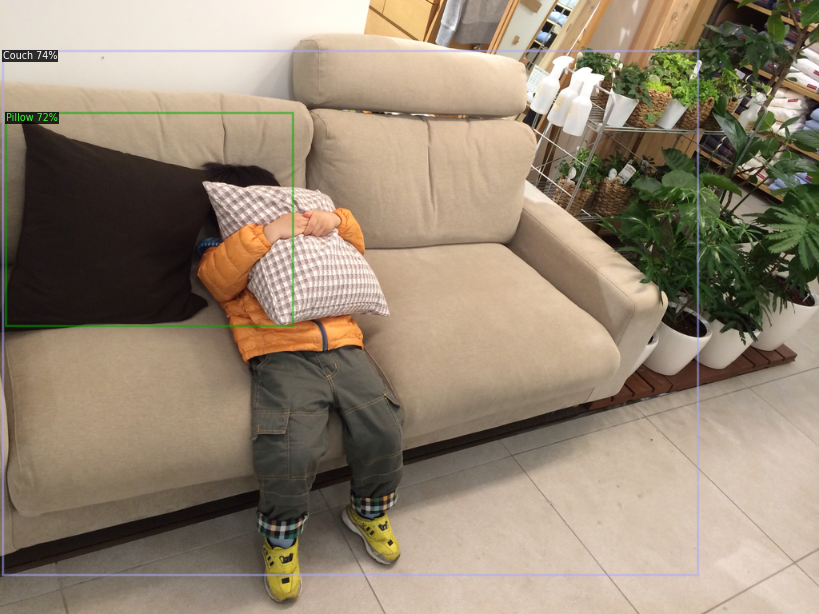

In [0]:
# visualize one image
im = cv2.imread(os.path.join(val_path, os.listdir(val_path)[502]))
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
                metadata=data_metadata, 
                scale=0.8 
)

v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

In [19]:
cfg2, model2 = main('R101-FPN-3x', resume = False)

[05/25 23:38:00 detectron2]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequ

model_final_280758.pkl: 167MB [00:16, 10.1MB/s]                           
'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (31, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (31,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (120, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (120,) in the model! Skipped.


[05/25 23:38:17 d2.data.build]: Removed 0 images with no usable annotations. 34835 images left.
[05/25 23:38:19 d2.data.common]: Serializing 34835 elements to byte tensors and concatenating them all ...
[05/25 23:38:19 d2.data.common]: Serialized dataset takes 10.88 MiB
[05/25 23:38:19 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[05/25 23:38:19 d2.data.build]: Using training sampler TrainingSampler
[05/25 23:38:19 detectron2]: Starting training from iteration 0
[05/25 23:38:29 d2.utils.events]:  iter: 20  total_loss: 3.363  loss_cls: 3.184  loss_box_reg: 0.072  loss_rpn_cls: 0.075  loss_rpn_loc: 0.011  lr: 0.000005  max_mem: 4970M
[05/25 23:38:38 d2.utils.events]:  eta: 2:35:43  iter: 40  total_loss: 3.191  loss_cls: 3.027  loss_box_reg: 0.095  loss_rpn_cls: 0.032  loss_rpn_loc: 0.010  lr: 0.000010  max_mem: 4970M
[05/25 23:38:47 d2.utils.events]:  et

In [20]:
# FINAL INFERENCE ON Test Dataset to see if model has overfitted
cfg2.DATASETS.TEST = ("data_test", )
predictor2 = DefaultPredictor(cfg2)
do_test(cfg2, model2)

[05/26 02:23:21 d2.data.common]: Serializing 2112 elements to byte tensors and concatenating them all ...
[05/26 02:23:21 d2.data.common]: Serialized dataset takes 0.65 MiB
[05/26 02:23:22 d2.evaluation.evaluator]: Start inference on 2112 images
[05/26 02:23:25 d2.evaluation.evaluator]: Inference done 11/2112. 0.0696 s / img. ETA=0:07:04
[05/26 02:23:30 d2.evaluation.evaluator]: Inference done 35/2112. 0.0695 s / img. ETA=0:07:21
[05/26 02:23:35 d2.evaluation.evaluator]: Inference done 61/2112. 0.0681 s / img. ETA=0:06:57
[05/26 02:23:40 d2.evaluation.evaluator]: Inference done 87/2112. 0.0684 s / img. ETA=0:06:49
[05/26 02:23:45 d2.evaluation.evaluator]: Inference done 113/2112. 0.0684 s / img. ETA=0:06:39
[05/26 02:23:50 d2.evaluation.evaluator]: Inference done 139/2112. 0.0683 s / img. ETA=0:06:33
[05/26 02:23:55 d2.evaluation.evaluator]: Inference done 165/2112. 0.0683 s / img. ETA=0:06:26
[05/26 02:24:00 d2.evaluation.evaluator]: Inference done 191/2112. 0.0679 s / img. ETA=0:06:1

OrderedDict([('bbox',
              {'AP': 28.766909850927302,
               'AP-Bathtub': 52.8782402573615,
               'AP-Bed': 50.70832689983663,
               'AP-Billiard table': 66.13464702811605,
               'AP-Ceiling fan': 27.428841247258944,
               'AP-Coffeemaker': 47.91662006356297,
               'AP-Couch': 24.70202737120508,
               'AP-Countertop': 13.138098151057076,
               'AP-Dishwasher': 0.0,
               'AP-Fireplace': 24.470721462337696,
               'AP-Fountain': 36.17654043036692,
               'AP-Gas stove': 12.488702772678968,
               'AP-Jacuzzi': 0.0,
               'AP-Kitchen & dining room table': 14.653719514085903,
               'AP-Microwave oven': 40.50083273011718,
               'AP-Mirror': 38.41435891370926,
               'AP-Oven': 20.873738830025143,
               'AP-Pillow': 20.05872752064416,
               'AP-Porch': 3.4498669435768674,
               'AP-Refrigerator': 58.293186422096944,
 

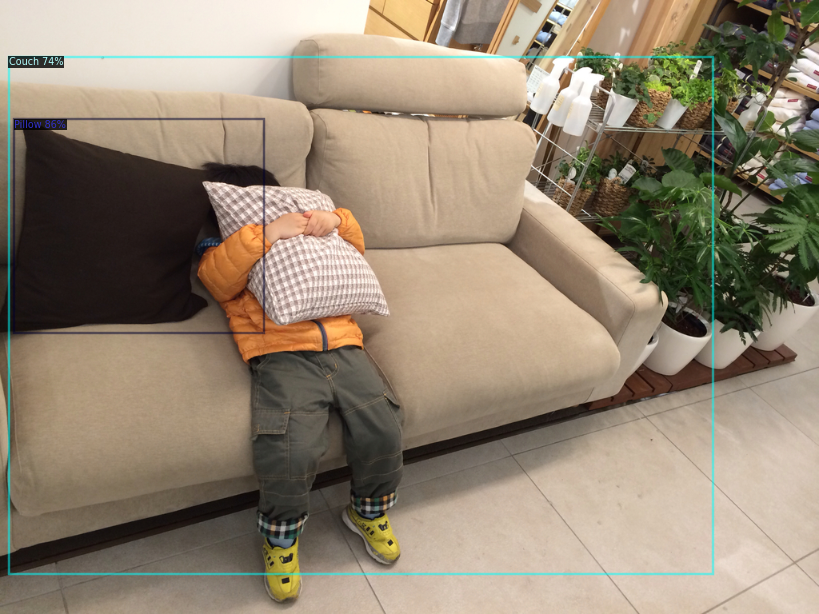

In [21]:
# visualize one image
im = cv2.imread(os.path.join(val_path, os.listdir(val_path)[502]))
outputs = predictor2(im)
v = Visualizer(im[:, :, ::-1],
                metadata=data_metadata, 
                scale=0.8 
)

v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

In [0]:
cfg3, model3 = main('RN-50-3x', resume = False)

Loading config /usr/local/lib/python3.6/dist-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


[05/24 12:43:35 detectron2]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequen

In [0]:
# FINAL INFERENCE ON Test Dataset to see if model has overfitted
cfg3.DATASETS.TEST = ("data_test", )
predictor3 = DefaultPredictor(cfg3)
do_test(cfg3, model3)

[05/24 18:03:30 d2.data.build]: Distribution of instances among all 30 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
|    Bathtub    | 59           |      Bed      | 328          | Billiard ta.. | 85           |
|  Ceiling fan  | 40           |  Coffeemaker  | 50           |     Couch     | 104          |
|  Countertop   | 143          |  Dishwasher   | 3            |   Fireplace   | 62           |
|   Fountain    | 63           |   Gas stove   | 49           |    Jacuzzi    | 28           |
| Kitchen & d.. | 157          | Microwave o.. | 46           |    Mirror     | 84           |
|     Oven      | 53           |    Pillow     | 264          |     Porch     | 100          |
| Refrigerator  | 82           |    Shower     | 32           |     Sink      | 119          |
|   Sofa bed    | 150          |    Stairs     | 122          

OrderedDict([('bbox',
              {'AP': 38.492384449355676,
               'AP-Bathtub': 60.115406677858815,
               'AP-Bed': 57.83057924335149,
               'AP-Billiard table': 75.51729046140261,
               'AP-Ceiling fan': 45.18986833756713,
               'AP-Coffeemaker': 51.970384613792795,
               'AP-Couch': 23.824464499510597,
               'AP-Countertop': 7.5333804114591345,
               'AP-Dishwasher': 0.2611187892244602,
               'AP-Fireplace': 42.060241857955674,
               'AP-Fountain': 44.873704286774775,
               'AP-Gas stove': 16.439547201431257,
               'AP-Jacuzzi': 15.70258672546233,
               'AP-Kitchen & dining room table': 11.599905718477451,
               'AP-Microwave oven': 45.02085736870218,
               'AP-Mirror': 43.812744467203615,
               'AP-Oven': 42.11172757937511,
               'AP-Pillow': 27.273736611804427,
               'AP-Porch': 5.555847755821968,
               'AP-Ref

In [0]:
# visualize one image
im = cv2.imread(os.path.join(val_path, os.listdir(val_path)[502]))
outputs = predictor3(im)
v = Visualizer(im[:, :, ::-1],
                metadata=data_metadata, 
                scale=0.8 
)

v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

IndexError: ignored

In [16]:
cfg4, model4 = main('RN-101-3x', resume = True)

Loading config /usr/local/lib/python3.6/dist-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


[05/25 22:33:51 detectron2]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequen

In [17]:
# FINAL INFERENCE ON Test Dataset to see if model has overfitted
cfg4.DATASETS.TEST = ("data_test", )
predictor4 = DefaultPredictor(cfg4)
do_test(cfg4, model4)

[05/25 23:27:34 d2.data.build]: Distribution of instances among all 30 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
|    Bathtub    | 59           |      Bed      | 328          | Billiard ta.. | 85           |
|  Ceiling fan  | 40           |  Coffeemaker  | 50           |     Couch     | 104          |
|  Countertop   | 143          |  Dishwasher   | 3            |   Fireplace   | 62           |
|   Fountain    | 63           |   Gas stove   | 49           |    Jacuzzi    | 28           |
| Kitchen & d.. | 157          | Microwave o.. | 46           |    Mirror     | 84           |
|     Oven      | 53           |    Pillow     | 264          |     Porch     | 100          |
| Refrigerator  | 82           |    Shower     | 32           |     Sink      | 119          |
|   Sofa bed    | 150          |    Stairs     | 122          

OrderedDict([('bbox',
              {'AP': 38.629005503971094,
               'AP-Bathtub': 57.88445796297448,
               'AP-Bed': 59.37857224325405,
               'AP-Billiard table': 76.94003410603575,
               'AP-Ceiling fan': 43.559413116751685,
               'AP-Coffeemaker': 48.989599570274635,
               'AP-Couch': 28.408037999550057,
               'AP-Countertop': 9.371518046833943,
               'AP-Dishwasher': 0.3057563835101482,
               'AP-Fireplace': 33.22536116260668,
               'AP-Fountain': 51.67562280533134,
               'AP-Gas stove': 12.330097602716778,
               'AP-Jacuzzi': 12.350546301821613,
               'AP-Kitchen & dining room table': 18.68710022505696,
               'AP-Microwave oven': 53.34352009331587,
               'AP-Mirror': 42.89079611781959,
               'AP-Oven': 36.861902837366436,
               'AP-Pillow': 27.396564938073226,
               'AP-Porch': 5.103006680850462,
               'AP-Refrig

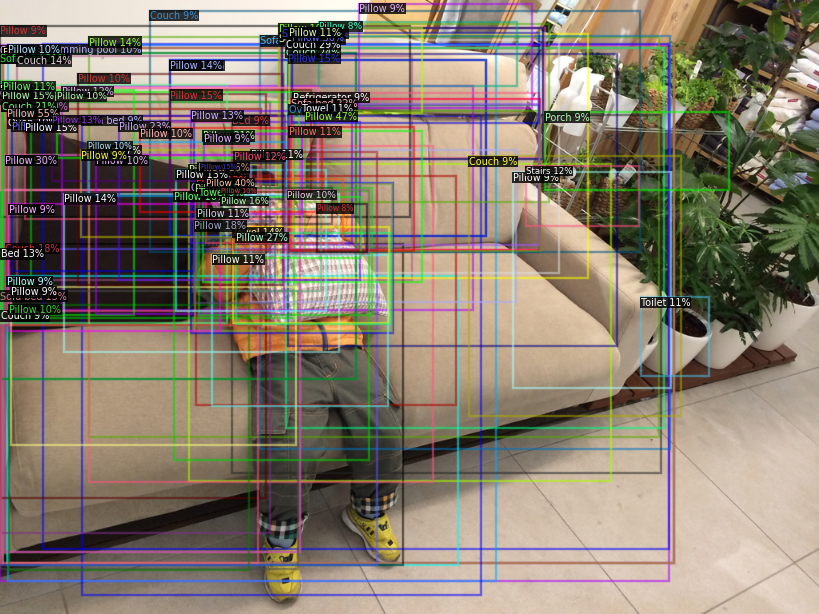

In [18]:
# visualize one image
im = cv2.imread(os.path.join(val_path, os.listdir(val_path)[502]))
outputs = predictor4(im)
v = Visualizer(im[:, :, ::-1],
                metadata=data_metadata, 
                scale=0.8 
)

v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])